# Step1: Initializing the main and target CNN models

In [1]:
# imports
import cv2
import math
import numpy as np
import random
# reinforcement learning related
import re
import atari_py as ap
from collections import deque
from gym import make, ObservationWrapper, Wrapper
from gym.spaces import Box
# PyTorch imports
import torch
import torch.nn as nn
from torch import save
from torch.optim import Adam
import ale_py
import gym
import matplotlib.pyplot as plt

### define the CNN model and functions such as forward passing and taking actions
It takes input size, total number of actions as input, output probability of taking each action;
the network has 3 convolutional layers with 32, 64, 64 filters with sizes 8* 8, 4* 4, 3*3

In [2]:
class CNN(nn.Module):
    def __init__(self, input_size, num_action):
        super(CNN,self).__init__()
        self._input_size = input_size
        self._num_action = num_action
        self.convLayer = nn.Sequential(
            nn.Conv2d(self._input_size[0],32,8,4),
            nn.ReLU(),
            nn.Conv2d(32,64,4,2),
            nn.ReLU(),
            nn.Conv2d(64,64,3,1),
            nn.ReLU()
        )
        self.linearLayer = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Linear(512,self._num_action)
        )
    def forward(self, x):
        # go through convolutional layers
        output = self.convLayer(x)
        # faltten the features
        output = output.view(x.size()[0],-1) # keep the batch dimension, and flatten the rest
        output = self.linearLayer(output)
        return output
    
    @property
    def feature_size(self):
        x = torch.zeros(1,*self._input_size)
        x = self.convLayer(x)
        return x.view(1,-1).size(1) # keep the first dimension as 1, and see what size the second
                                     #  dimension after flatten
    
    def take_action(self, state, eps, device):
        if random.random() > eps: # being greedy
            state = torch.from_numpy(np.double(state)).unsqueeze(0).to(device) # convert 
                #  state to float, increase a dimension, then sent to device where the model is
            state = state.float()
            # calculate Q values for each available action
            Q = self.forward(state)
            
            # choose an action accordingly
            #  torch.max(a,1) returns max values and their indices, we want the index
            #  representing the action with max Q value
            action = Q.max(1)[1].item()
        
        else: # select actions randomly
            action = random.randrange(self._num_action)
        return action
        
        

In [3]:
random.randrange(10)

8

### define the function that instantiates the main neural network and the target neural network

In [4]:
# Add the option to load trained weights!!!!!!!!!!!!
def model_initialize(env,device,path):
    main_model = CNN(env.observation_space.shape,env.action_space.n).to(device)
    target_model = CNN(env.observation_space.shape,env.action_space.n).to(device)
    if path is not None:
        main_model.load_state_dict(torch.load(path))
        target_model.load_state_dict(torch.load(path))
        print("Weights loaded")
    #print(main_model)
    return main_model, target_model

# Step2: define the experience replay buffer
store transitions (frames) of the game to train the CNN model with random sampling

In [5]:
class ReplayBuffer:
    def __init__(self, cap_max):
        # cap_max is the defined buffer size, the number of state trasitions that stored in the buffer
        self._buffer = deque(maxlen=cap_max) # use deque to speed up the append and pop operations
    
    # append (state, action, reward, next state, finish) tuple
    def push(self, state, action, reward, next_state, finish):
        self._buffer.append((state,action,reward,next_state,finish))
    
    
    def sample(self, batch_size):
        idxs = np.random.choice(len(self._buffer),batch_size,False) # chose random samples
        # e.g. idxs = (1,5,67,51,34,97,105,...)
        
        batch = zip(*[self._buffer[i] for i in idxs]) # put corresponding frames to a zipped list
        # e.g. batch = ((state_1,action_1.reward_1,next_state_1,finish_1),
        #                (state_5,action_5,reward_5,next_state_5,finish_5, ...)
        
        state, action, reward, next_state, finish = batch # create array for each category
        # e.g. state = (state_1,state_5,state_67,...)
        #      action = (action_1, action_5, action_67, ...)
        #      ...
        return (np.array(state),np.array(action),np.array(reward,dtype=float),
                 np.array(next_state),np.array(finish,dtype=np.uint8))
    
    def __len__(self):
        return len(self._buffer)

In [6]:
a = np.array([1,2,3,4,5,6,7])
np.random.choice(len(a),3,False)

array([0, 4, 5])

# Step 3: setting up environment

### define some initialization-related functions

In [7]:
# replace some string with _
def gym_to_atari_format(gym_env):
    return re.sub(r"(?<!^)(?=[A-Z])", "_", gym_env).lower()

# 
def check_atari_env(env):
    for f in ["Deterministic", "ramDeterministic", "ram", "NoFrameskip", "ramNoFrameSkip"]:
        env = env.replace(f, "")
    env = re.sub(r"-v\d+", "", env)
    env = gym_to_atari_format(env) 
    return True if env in ap.list_games() else False

### augment gym environment in a series of steps, 
include 1) downsampling the video game image frames, 2) pushing iamge frames to the experience replay buffer 3) converting images into PyTorch tnesors, ...  

In [8]:
# reseting environment for both atari or non-atari environment
class CCtrl(Wrapper):
    def __init__(self,env,is_atari):
        super(CCtrl,self).__init__(env)
        self._is_atari = is_atari
        
    def reset(self):
        if self._is_atari:
            return self.env.reset()
        else:
            self.env.reset()
            return self.env.render(mode="rgb_array")

# observations (frames) will be converted to grey-scale and reshape to (84,84)
class FrmDwSmpl(ObservationWrapper):
    def __init__(self, env):
        super(FrmDwSmpl,self).__init__(env)
        self.observation_space = Box(low=0,high=255,shape=(84,84,1),dtype=np.uint8)
        self._width=84
        self._height = 84
        
    def observation(self,observation):
        frame = cv2.cvtColor(observation,cv2.COLOR_RGB2GRAY) # turn the image to gray
        frame = cv2.resize(frame,(self._width,self._height), interpolation=cv2.INTER_AREA)
        return frame[:,:,None]
    
    
# use frame-skipping technique
class MaxNSkpEnv(Wrapper):
    def __init__(self, env, atari, skip=4):
        super(MaxNSkpEnv,self).__init__(env)
        self._obs_buffer = deque(maxlen=2)
        self._skip = skip
        self._atari = atari
    
    def step(self,action):
        total_reward = 0
        finish = None
        for _ in range(self._skip):
            # take a step
            obs, reward, finish, log = self.env.step(action)
            if not self._atari:
                obs = self.env.render(mode="rgb_array")
            # append the new stsate to the double ended queue buffer
            self._obs_buffer.append(obs)
            # accumulate the reward
            total_reward += reward
            if finish:
                break
        # buffer holds the last two frames, they are max-pooled, resulting in an observation
        #  that contains some temporal information
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, finish, log
    
    def reset(self):
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs
    
    

class FrRstEnv(Wrapper):
    def __init__(self,env):
        Wrapper.__init__(self,env)
        if len(env.unwrapped.get_action_meanings()) < 3:
            raise ValueError("min requred action space of 3!")
    
    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs,_,finish,_ = self.env.step(1)
        if finish:
            self.env.reset(**kwargs)
        obs,_,finish,_ = self.env.step(2)
        if finish:
            self.env.reset(**kwargs)
        return obs
    
    def step(self, action):
        return self.env.step(action)
    

class FrmBfr(ObservationWrapper):
    def __init__(self,env,num_steps,dtype=float):
        super(FrmBfr,self).__init__(env)
        obs_space = env.observation_space
        self._dtype = dtype
        self.observation_space = Box(obs_space.low.repeat(num_steps,axis=0),
                        obs_space.high.repeat(num_steps,axis=0), dtype=self._dtype)
    
    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low,dtype=self._dtype)
        return self.observation(self.env.reset())
    
    def observation(self,observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer
#
class Img2Trch(ObservationWrapper):
    def __init__(self,env):
        super(Img2Trch,self).__init__(env)
        obs_shape = self.observation_space.shape
        self.observation_space = Box(low=0,high=1,shape=(obs_shape[::-1]),dtype=float)
    
    def observation(self,observation):
        # move the last channel to the first place, experiment!!!!!!!
        return np.moveaxis(observation,2,0)

# normalizing pixel values
class NormFlts(ObservationWrapper):
    def observation(self,obs):
        return np.array(obs).astype(float) / 255




In [9]:
# experimenting deque
a = deque(maxlen=2)
a.append(10)
a.append(20)
print("original container: ",a," with max length 2")
a.append(3)
print("append 3 to the right: ", a)
a.append(4)
print("append another 4 to the right", a)
print("\nnew appended value to the right would push out the observations to the left\n")

a.appendleft(20)
print("append 20 to the left: ", a)
a.appendleft(10)
print("append 10 to the left: ", a)

print("\nnew appended value to the left would push out the observations to the right\n")


original container:  deque([10, 20], maxlen=2)  with max length 2
append 3 to the right:  deque([20, 3], maxlen=2)
append another 4 to the right deque([3, 4], maxlen=2)

new appended value to the right would push out the observations to the left

append 20 to the left:  deque([20, 3], maxlen=2)
append 10 to the left:  deque([10, 20], maxlen=2)

new appended value to the left would push out the observations to the right



In [10]:
# experimenting np.max
d = []
a = [1,2,10,4]
d.append(a)
b = [2,9,4,5]
d.append(b)
c= [3,4,5,6]
d.append(c)
print("original list: \n", d)
e = np.stack(d)
print("after stack: \n", e)
f = np.max(e,0)
print("np.max applied through axis = 0: \n", f)
print("This chooses the max value for each column")


original list: 
 [[1, 2, 10, 4], [2, 9, 4, 5], [3, 4, 5, 6]]
after stack: 
 [[ 1  2 10  4]
 [ 2  9  4  5]
 [ 3  4  5  6]]
np.max applied through axis = 0: 
 [ 3  9 10  6]
This chooses the max value for each column


define a method that takes in the raw Pong video game environment as input and augments the environment, as follows:

In [11]:
def wrap_env(env_ip):
    env = gym.make(env_ip)
    is_atari = check_atari_env(env_ip) 
    env = CCtrl(env, is_atari) # preparing to reseting environment
    env = MaxNSkpEnv(env, is_atari) # initialize frame-skipping technique
    try:
        env_acts = env.unwrapped.get_action_meanings()
        if "FIRE" in env_acts:
            env = FrRstEnv(env)
    except AttributeError:
        pass
    env = FrmDwSmpl(env) # preprocessing pixels
    env = Img2Trch(env) # convert to tensor 
    env = FrmBfr(env,4) # initilize frame buffers
    env = NormFlts(env) # normalize pixel values
    return env
        

# Step 4: Defining the CNN optimization function

In [12]:
def convert(data,device):
    # data should be a numpy array
    return torch.from_numpy(data).to(device)

In [13]:
# loss function
def calc_temp_diff_loss(main_model,target_model,batch,gamma,device):
    state, action, reward, next_state, finish = batch
    
    # put tensors to cuda
    state = convert(state,device).float() 
    next_state = convert(next_state,device).float()
    action = convert(action,device)
    reward = convert(reward,device)
    finish = convert(finish,device)
    
    # use behavior policy to calculate current state action values
    Q_vals = main_model(state)
    
    # use target policy (greedy) to calculate state action values for next state
    next_Q_vals = target_model(next_state)
    
    action = action.long()
    
    # experiment!!!!!!!!!!!!!!!!!!
    Q_val = Q_vals.gather(1,action.unsqueeze(-1)).squeeze(-1)
    
    # index 0 because we wish to know the max q-value for next state, not which action that cause the max value
    next_Q_val = next_Q_vals.max(1)[0]
    
    # calculate the loss 
    expected_Q_val = reward + gamma * next_Q_val * (1-finish) 
    loss = (Q_val - expected_Q_val.data.to(device)).pow(2).mean() # SSE
    
    return loss

In [14]:
# updating function: samples a batch of data from the reperiemnce replay buffer,
#  computes the time difference loss on the batch, copies the weights of the main model
#  to the target model once every TGT_UPD_FRQ iterations
def update_graph(main_model,target_model,opt,buffer,device,log):
    if len(buffer) > INIT_LEARN:
        # copy the wieghts main model to target model every 1000 iterations
        if log.idx % TGT_UPD_FRQ == 0: 
            target_model.load_state_dict(main_model.state_dict())
        
        # calculate predictions (action values) loss and update the weights in the model 
        opt.zero_grad() # clear cache
        batch = buffer.sample(B_S) # B_S is hyperparameter, sample B_S tuples of (state,...)
        loss = calc_temp_diff_loss(main_model,target_model,batch,G, device)
        loss.backward()
        opt.step()

# Step5: managing and running episodes

In [15]:
# define the function to update the epsillon value after each episode
def update_eps(epd):
    last_eps = EPS_FINL
    first_eps = EPS_START
    eps_decay = EPS_DECAY
    if last_eps < first_eps:
        eps = last_eps + (first_eps - last_eps) * math.exp(-1*((epd+1)/eps_decay))
    else:
        eps = last_eps
    return eps

In [16]:
# define the function to take action after end of an episode
#  if the overall reward that's scored in the current episode is the best we've achieved so far
#  we save the CNN model weights and print the reward value
def finish_episode(main_model,env,log,ep_reward,ep,eps):
    best_so_far = log.update_rewards(ep_reward)
    log.update_average_rewards()
    if best_so_far:
        print(f"\nhighest running_average_reward of {round(log.best_average,3)} achieved!\n")
        save(main_model.state_dict(),f"Weights/{env}.pth")
    print(f"EP {ep}, curr_reward: {ep_reward}, best_reward: {log.best_reward}, running_avg_reward: {round(log.average, 3)}, curr_epsilon: {round(eps, 4)}")

In [17]:
# define the DQN loop
def run_episodes(env,main_model,target_model,optimizer,buffer,device,log,ep):
    # initializing
    episode_reward = 0.0
    state = env.reset()
    
    while True: 
        eps = update_eps(log.idx) # update episolon based on current episode number
        action = main_model.take_action(state,eps,device) # choose an action to take
        env.render() # display the environment
        next_state, reward, finish, _ = env.step(action)  # take the action
        buffer.push(state,action,reward,next_state,finish) # push current tuple to buffer
        
        # prepare for next iteration
        state = next_state 
        episode_reward += reward
        log.update_idx()
        update_graph(main_model,target_model,optimizer,buffer,device,log) # perform learning
        
        # break if reached end of the episode
        if finish:
            finish_episode(main_model,ENV,log,episode_reward,ep,eps)
            break

# Step 6: define the matadata class

In [18]:
class TrMetadata:
    def __init__(self):
        self._average = 0.0
        self._best_reward = -float("inf")
        self._best_average = -float("inf")
        self._rewards = []
        self._average_rewards = [] # keep track of average rewards
        self._average_range = 100
        self._idx = 0
        self._best_rewards = [] # keep track of best rewards
    
    @property
    def best_reward(self):
        return self._best_reward
    
    @property
    def best_average(self):
        return self._best_average
    
    @property
    def average(self):
        average_range = self._average_range * -1
        average_reward = sum(self._rewards[average_range:]) / len(self._rewards[average_range:])
        return average_reward
    
    @property
    def idx(self):
        return self._idx
    
    def _update_best_reward(self,episode_reward):
        self._best_rewards.append(self._best_reward)
        if episode_reward > self.best_reward:
            self._best_reward = episode_reward
            
    
    def _update_best_average(self):
        if self.average > self.best_average:
            self._best_average = self.average
            return True
        return False
    
    def update_rewards(self,episode_reward):
        self._rewards.append(episode_reward)
        self._update_best_reward(episode_reward)
        return self._update_best_average()
    
    def update_average_rewards(self):
        self._average_rewards.append(self.average)
    
    def update_idx(self):
        self._idx += 1

# Step 7: training

In [19]:
from tqdm.auto import tqdm
def train(env,main_model,target_model,optimizer,buffer,device):
    log = TrMetadata()
    progress = tqdm(range(N_EPDS))
    for ep in np.arange(N_EPDS):
        run_episodes(env,main_model,target_model,optimizer,buffer,device,log,ep)
        progress.update(1)
    # return rewrads and average rewards
    return log._average_rewards, log._rewards, log._best_rewards

In [25]:
# hypterparameters 
B_S = 64 # batch size per SGD calculation
ENV = "Pong-v4"
EPS_START = 1.0
EPS_FINL = 0.005
EPS_DECAY = 100000
G = 1 # gamma
INIT_LEARN = 64 # initial number of iterations that are reserved for pushing data
                   #  to the buffer
LR = 1e-4
MEM_CAP = 20000 #size of experience replay buffer

TGT_UPD_FRQ = 1000

# Initialization - run every time

In [21]:
# start training
env = wrap_env(ENV)
device = "cuda"
path = None
main_model, target_model = model_initialize(env,device,path)
optimizer = Adam(main_model.parameters(),lr=LR)
buffer = ReplayBuffer(MEM_CAP)


In [37]:
def plot_rewards(re,num_eps,reward_type,run):
    # plot and save the figure
    plt.figure(figsize=(12,8))
    x = np.arange(1,num_eps+1)
    filepath = "Figs/run_"+str(run)+"_"+reward_type+"_"+str(num_eps)+"_episode.jpg"
    plt.plot(x,re)
    plt.xlabel("Episodes")
    plt.ylabel(f"{reward_type} Reward")
    plt.title(f"{reward_type} rewards for the first {num_eps} episodes")
    plt.savefig(filepath)
    plt.show()
    
    # save the array
    arraypath = "Rewards/run_"+str(run)+"_"+reward_type+"_"+str(num_eps)+"_episode.npy"
    np.save(arraypath,re)
    

# 1000 episodes

In [26]:
N_EPDS = 1500  # total number of episodes to train the agent for
EPS_START = 0.8
ave_re, re, best_re = train(env,main_model,target_model,optimizer,buffer,device)
env.close()

  0%|          | 0/1500 [00:00<?, ?it/s]


highest running_average_reward of -21.0 achieved!

EP 0, curr_reward: -21.0, best_reward: -21.0, running_avg_reward: -21.0, curr_epsilon: 0.7979
EP 1, curr_reward: -21.0, best_reward: -21.0, running_avg_reward: -21.0, curr_epsilon: 0.7957

highest running_average_reward of -20.667 achieved!

EP 2, curr_reward: -20.0, best_reward: -20.0, running_avg_reward: -20.667, curr_epsilon: 0.7933
EP 3, curr_reward: -21.0, best_reward: -20.0, running_avg_reward: -20.75, curr_epsilon: 0.7909

highest running_average_reward of -20.6 achieved!

EP 4, curr_reward: -20.0, best_reward: -20.0, running_avg_reward: -20.6, curr_epsilon: 0.7884
EP 5, curr_reward: -21.0, best_reward: -20.0, running_avg_reward: -20.667, curr_epsilon: 0.7861
EP 6, curr_reward: -21.0, best_reward: -20.0, running_avg_reward: -20.714, curr_epsilon: 0.7839
EP 7, curr_reward: -21.0, best_reward: -20.0, running_avg_reward: -20.75, curr_epsilon: 0.7814
EP 8, curr_reward: -21.0, best_reward: -20.0, running_avg_reward: -20.778, curr_ep


highest running_average_reward of -20.11 achieved!

EP 72, curr_reward: -20.0, best_reward: -18.0, running_avg_reward: -20.11, curr_epsilon: 0.63
EP 73, curr_reward: -21.0, best_reward: -18.0, running_avg_reward: -20.122, curr_epsilon: 0.6279
EP 74, curr_reward: -20.0, best_reward: -18.0, running_avg_reward: -20.12, curr_epsilon: 0.6255
EP 75, curr_reward: -20.0, best_reward: -18.0, running_avg_reward: -20.118, curr_epsilon: 0.6233
EP 76, curr_reward: -20.0, best_reward: -18.0, running_avg_reward: -20.117, curr_epsilon: 0.6213
EP 77, curr_reward: -21.0, best_reward: -18.0, running_avg_reward: -20.128, curr_epsilon: 0.6194
EP 78, curr_reward: -20.0, best_reward: -18.0, running_avg_reward: -20.127, curr_epsilon: 0.617
EP 79, curr_reward: -21.0, best_reward: -18.0, running_avg_reward: -20.137, curr_epsilon: 0.615
EP 80, curr_reward: -18.0, best_reward: -18.0, running_avg_reward: -20.111, curr_epsilon: 0.6121
EP 81, curr_reward: -21.0, best_reward: -18.0, running_avg_reward: -20.122, curr


highest running_average_reward of -19.64 achieved!

EP 139, curr_reward: -19.0, best_reward: -17.0, running_avg_reward: -19.64, curr_epsilon: 0.4893

highest running_average_reward of -19.61 achieved!

EP 140, curr_reward: -16.0, best_reward: -16.0, running_avg_reward: -19.61, curr_epsilon: 0.4868

highest running_average_reward of -19.6 achieved!

EP 141, curr_reward: -19.0, best_reward: -16.0, running_avg_reward: -19.6, curr_epsilon: 0.4848

highest running_average_reward of -19.59 achieved!

EP 142, curr_reward: -20.0, best_reward: -16.0, running_avg_reward: -19.59, curr_epsilon: 0.483
EP 143, curr_reward: -21.0, best_reward: -16.0, running_avg_reward: -19.6, curr_epsilon: 0.4813
EP 144, curr_reward: -18.0, best_reward: -16.0, running_avg_reward: -19.59, curr_epsilon: 0.4791

highest running_average_reward of -19.58 achieved!

EP 145, curr_reward: -20.0, best_reward: -16.0, running_avg_reward: -19.58, curr_epsilon: 0.4771
EP 146, curr_reward: -20.0, best_reward: -16.0, running_avg_

EP 213, curr_reward: -20.0, best_reward: -15.0, running_avg_reward: -19.28, curr_epsilon: 0.3589
EP 214, curr_reward: -19.0, best_reward: -15.0, running_avg_reward: -19.27, curr_epsilon: 0.3573
EP 215, curr_reward: -20.0, best_reward: -15.0, running_avg_reward: -19.28, curr_epsilon: 0.3551
EP 216, curr_reward: -20.0, best_reward: -15.0, running_avg_reward: -19.31, curr_epsilon: 0.3535
EP 217, curr_reward: -16.0, best_reward: -15.0, running_avg_reward: -19.28, curr_epsilon: 0.3515

highest running_average_reward of -19.25 achieved!

EP 218, curr_reward: -16.0, best_reward: -15.0, running_avg_reward: -19.25, curr_epsilon: 0.3497

highest running_average_reward of -19.24 achieved!

EP 219, curr_reward: -19.0, best_reward: -15.0, running_avg_reward: -19.24, curr_epsilon: 0.3481

highest running_average_reward of -19.2 achieved!

EP 220, curr_reward: -17.0, best_reward: -15.0, running_avg_reward: -19.2, curr_epsilon: 0.3468

highest running_average_reward of -19.18 achieved!

EP 221, curr_r


highest running_average_reward of -18.29 achieved!

EP 278, curr_reward: -12.0, best_reward: -12.0, running_avg_reward: -18.29, curr_epsilon: 0.26
EP 279, curr_reward: -18.0, best_reward: -12.0, running_avg_reward: -18.29, curr_epsilon: 0.2587

highest running_average_reward of -18.28 achieved!

EP 280, curr_reward: -20.0, best_reward: -12.0, running_avg_reward: -18.28, curr_epsilon: 0.2573
EP 281, curr_reward: -21.0, best_reward: -12.0, running_avg_reward: -18.29, curr_epsilon: 0.2562

highest running_average_reward of -18.27 achieved!

EP 282, curr_reward: -18.0, best_reward: -12.0, running_avg_reward: -18.27, curr_epsilon: 0.2551
EP 283, curr_reward: -21.0, best_reward: -12.0, running_avg_reward: -18.3, curr_epsilon: 0.2541
EP 284, curr_reward: -18.0, best_reward: -12.0, running_avg_reward: -18.27, curr_epsilon: 0.2525
EP 285, curr_reward: -21.0, best_reward: -12.0, running_avg_reward: -18.29, curr_epsilon: 0.2514

highest running_average_reward of -18.24 achieved!

EP 286, curr_re


highest running_average_reward of -17.58 achieved!

EP 349, curr_reward: -19.0, best_reward: -12.0, running_avg_reward: -17.58, curr_epsilon: 0.1783
EP 350, curr_reward: -18.0, best_reward: -12.0, running_avg_reward: -17.59, curr_epsilon: 0.1773
EP 351, curr_reward: -20.0, best_reward: -12.0, running_avg_reward: -17.63, curr_epsilon: 0.1765
EP 352, curr_reward: -20.0, best_reward: -12.0, running_avg_reward: -17.66, curr_epsilon: 0.1755
EP 353, curr_reward: -15.0, best_reward: -12.0, running_avg_reward: -17.62, curr_epsilon: 0.1743
EP 354, curr_reward: -15.0, best_reward: -12.0, running_avg_reward: -17.58, curr_epsilon: 0.1733

highest running_average_reward of -17.57 achieved!

EP 355, curr_reward: -18.0, best_reward: -12.0, running_avg_reward: -17.57, curr_epsilon: 0.1724
EP 356, curr_reward: -18.0, best_reward: -12.0, running_avg_reward: -17.61, curr_epsilon: 0.1713
EP 357, curr_reward: -17.0, best_reward: -12.0, running_avg_reward: -17.59, curr_epsilon: 0.1703
EP 358, curr_reward: 

EP 420, curr_reward: -20.0, best_reward: -9.0, running_avg_reward: -16.92, curr_epsilon: 0.1162
EP 421, curr_reward: -17.0, best_reward: -9.0, running_avg_reward: -16.93, curr_epsilon: 0.1156
EP 422, curr_reward: -16.0, best_reward: -9.0, running_avg_reward: -16.91, curr_epsilon: 0.1149

highest running_average_reward of -16.81 achieved!

EP 423, curr_reward: -10.0, best_reward: -9.0, running_avg_reward: -16.81, curr_epsilon: 0.114
EP 424, curr_reward: -19.0, best_reward: -9.0, running_avg_reward: -16.82, curr_epsilon: 0.1133

highest running_average_reward of -16.8 achieved!

EP 425, curr_reward: -17.0, best_reward: -9.0, running_avg_reward: -16.8, curr_epsilon: 0.1125
EP 426, curr_reward: -17.0, best_reward: -9.0, running_avg_reward: -16.82, curr_epsilon: 0.1118
EP 427, curr_reward: -17.0, best_reward: -9.0, running_avg_reward: -16.83, curr_epsilon: 0.1113
EP 428, curr_reward: -14.0, best_reward: -9.0, running_avg_reward: -16.8, curr_epsilon: 0.1104

highest running_average_reward of

EP 489, curr_reward: -18.0, best_reward: -7.0, running_avg_reward: -15.68, curr_epsilon: 0.0736

highest running_average_reward of -15.62 achieved!

EP 490, curr_reward: -11.0, best_reward: -7.0, running_avg_reward: -15.62, curr_epsilon: 0.0731

highest running_average_reward of -15.55 achieved!

EP 491, curr_reward: -13.0, best_reward: -7.0, running_avg_reward: -15.55, curr_epsilon: 0.0724

highest running_average_reward of -15.54 achieved!

EP 492, curr_reward: -15.0, best_reward: -7.0, running_avg_reward: -15.54, curr_epsilon: 0.072
EP 493, curr_reward: -15.0, best_reward: -7.0, running_avg_reward: -15.56, curr_epsilon: 0.0715

highest running_average_reward of -15.51 achieved!

EP 494, curr_reward: -12.0, best_reward: -7.0, running_avg_reward: -15.51, curr_epsilon: 0.071

highest running_average_reward of -15.5 achieved!

EP 495, curr_reward: -16.0, best_reward: -7.0, running_avg_reward: -15.5, curr_epsilon: 0.0706

highest running_average_reward of -15.46 achieved!

EP 496, curr_r


highest running_average_reward of -13.78 achieved!

EP 556, curr_reward: -9.0, best_reward: -3.0, running_avg_reward: -13.78, curr_epsilon: 0.0446
EP 557, curr_reward: -13.0, best_reward: -3.0, running_avg_reward: -13.81, curr_epsilon: 0.0443
EP 558, curr_reward: -16.0, best_reward: -3.0, running_avg_reward: -13.82, curr_epsilon: 0.044
EP 559, curr_reward: -12.0, best_reward: -3.0, running_avg_reward: -13.79, curr_epsilon: 0.0437

highest running_average_reward of -13.74 achieved!

EP 560, curr_reward: -10.0, best_reward: -3.0, running_avg_reward: -13.74, curr_epsilon: 0.0433

highest running_average_reward of -13.68 achieved!

EP 561, curr_reward: -10.0, best_reward: -3.0, running_avg_reward: -13.68, curr_epsilon: 0.043
EP 562, curr_reward: -18.0, best_reward: -3.0, running_avg_reward: -13.69, curr_epsilon: 0.0428

highest running_average_reward of -13.59 achieved!

EP 563, curr_reward: -10.0, best_reward: -3.0, running_avg_reward: -13.59, curr_epsilon: 0.0424
EP 564, curr_reward: -1

EP 633, curr_reward: -12.0, best_reward: -3.0, running_avg_reward: -13.41, curr_epsilon: 0.0253
EP 634, curr_reward: -8.0, best_reward: -3.0, running_avg_reward: -13.38, curr_epsilon: 0.0251
EP 635, curr_reward: -13.0, best_reward: -3.0, running_avg_reward: -13.38, curr_epsilon: 0.0249
EP 636, curr_reward: -2.0, best_reward: -2.0, running_avg_reward: -13.33, curr_epsilon: 0.0247
EP 637, curr_reward: -17.0, best_reward: -2.0, running_avg_reward: -13.34, curr_epsilon: 0.0245
EP 638, curr_reward: -12.0, best_reward: -2.0, running_avg_reward: -13.36, curr_epsilon: 0.0243
EP 639, curr_reward: -14.0, best_reward: -2.0, running_avg_reward: -13.42, curr_epsilon: 0.0242
EP 640, curr_reward: -11.0, best_reward: -2.0, running_avg_reward: -13.43, curr_epsilon: 0.024
EP 641, curr_reward: -16.0, best_reward: -2.0, running_avg_reward: -13.45, curr_epsilon: 0.0238
EP 642, curr_reward: -15.0, best_reward: -2.0, running_avg_reward: -13.45, curr_epsilon: 0.0237
EP 643, curr_reward: -13.0, best_reward: -2


highest running_average_reward of -12.44 achieved!

EP 712, curr_reward: -14.0, best_reward: 3.0, running_avg_reward: -12.44, curr_epsilon: 0.0144
EP 713, curr_reward: -16.0, best_reward: 3.0, running_avg_reward: -12.45, curr_epsilon: 0.0143

highest running_average_reward of -12.39 achieved!

EP 714, curr_reward: -9.0, best_reward: 3.0, running_avg_reward: -12.39, curr_epsilon: 0.0142

highest running_average_reward of -12.28 achieved!

EP 715, curr_reward: -6.0, best_reward: 3.0, running_avg_reward: -12.28, curr_epsilon: 0.0141

highest running_average_reward of -12.26 achieved!

EP 716, curr_reward: -17.0, best_reward: 3.0, running_avg_reward: -12.26, curr_epsilon: 0.014
EP 717, curr_reward: -13.0, best_reward: 3.0, running_avg_reward: -12.31, curr_epsilon: 0.0139
EP 718, curr_reward: -11.0, best_reward: 3.0, running_avg_reward: -12.28, curr_epsilon: 0.0138

highest running_average_reward of -12.24 achieved!

EP 719, curr_reward: -13.0, best_reward: 3.0, running_avg_reward: -12.24,

EP 788, curr_reward: -19.0, best_reward: 3.0, running_avg_reward: -11.87, curr_epsilon: 0.0095
EP 789, curr_reward: -16.0, best_reward: 3.0, running_avg_reward: -11.93, curr_epsilon: 0.0094
EP 790, curr_reward: -7.0, best_reward: 3.0, running_avg_reward: -11.94, curr_epsilon: 0.0094
EP 791, curr_reward: -11.0, best_reward: 3.0, running_avg_reward: -11.93, curr_epsilon: 0.0093
EP 792, curr_reward: -19.0, best_reward: 3.0, running_avg_reward: -12.04, curr_epsilon: 0.0093
EP 793, curr_reward: -14.0, best_reward: 3.0, running_avg_reward: -12.06, curr_epsilon: 0.0093
EP 794, curr_reward: -21.0, best_reward: 3.0, running_avg_reward: -12.16, curr_epsilon: 0.0092
EP 795, curr_reward: -1.0, best_reward: 3.0, running_avg_reward: -12.0, curr_epsilon: 0.0092
EP 796, curr_reward: -15.0, best_reward: 3.0, running_avg_reward: -11.98, curr_epsilon: 0.0092
EP 797, curr_reward: -19.0, best_reward: 3.0, running_avg_reward: -12.04, curr_epsilon: 0.0091
EP 798, curr_reward: -8.0, best_reward: 3.0, running_


highest running_average_reward of -10.45 achieved!

EP 864, curr_reward: -4.0, best_reward: 5.0, running_avg_reward: -10.45, curr_epsilon: 0.0071
EP 865, curr_reward: -14.0, best_reward: 5.0, running_avg_reward: -10.48, curr_epsilon: 0.0071

highest running_average_reward of -10.34 achieved!

EP 866, curr_reward: -3.0, best_reward: 5.0, running_avg_reward: -10.34, curr_epsilon: 0.0071

highest running_average_reward of -10.24 achieved!

EP 867, curr_reward: -1.0, best_reward: 5.0, running_avg_reward: -10.24, curr_epsilon: 0.0071
EP 868, curr_reward: -9.0, best_reward: 5.0, running_avg_reward: -10.25, curr_epsilon: 0.0071
EP 869, curr_reward: -14.0, best_reward: 5.0, running_avg_reward: -10.37, curr_epsilon: 0.007
EP 870, curr_reward: -11.0, best_reward: 5.0, running_avg_reward: -10.38, curr_epsilon: 0.007
EP 871, curr_reward: -10.0, best_reward: 5.0, running_avg_reward: -10.34, curr_epsilon: 0.007
EP 872, curr_reward: -6.0, best_reward: 5.0, running_avg_reward: -10.29, curr_epsilon: 0


highest running_average_reward of -6.42 achieved!

EP 929, curr_reward: -1.0, best_reward: 11.0, running_avg_reward: -6.42, curr_epsilon: 0.0061

highest running_average_reward of -6.23 achieved!

EP 930, curr_reward: 4.0, best_reward: 11.0, running_avg_reward: -6.23, curr_epsilon: 0.0061

highest running_average_reward of -6.15 achieved!

EP 931, curr_reward: -8.0, best_reward: 11.0, running_avg_reward: -6.15, curr_epsilon: 0.0061

highest running_average_reward of -5.9 achieved!

EP 932, curr_reward: 9.0, best_reward: 11.0, running_avg_reward: -5.9, curr_epsilon: 0.0061
EP 933, curr_reward: -10.0, best_reward: 11.0, running_avg_reward: -5.99, curr_epsilon: 0.0061

highest running_average_reward of -5.87 achieved!

EP 934, curr_reward: -1.0, best_reward: 11.0, running_avg_reward: -5.87, curr_epsilon: 0.0061

highest running_average_reward of -5.77 achieved!

EP 935, curr_reward: -6.0, best_reward: 11.0, running_avg_reward: -5.77, curr_epsilon: 0.006

highest running_average_reward of

EP 988, curr_reward: -9.0, best_reward: 15.0, running_avg_reward: -0.59, curr_epsilon: 0.0056

highest running_average_reward of -0.4 achieved!

EP 989, curr_reward: 8.0, best_reward: 15.0, running_avg_reward: -0.4, curr_epsilon: 0.0056

highest running_average_reward of -0.17 achieved!

EP 990, curr_reward: 14.0, best_reward: 15.0, running_avg_reward: -0.17, curr_epsilon: 0.0056

highest running_average_reward of -0.09 achieved!

EP 991, curr_reward: 7.0, best_reward: 15.0, running_avg_reward: -0.09, curr_epsilon: 0.0056

highest running_average_reward of 0.08 achieved!

EP 992, curr_reward: 8.0, best_reward: 15.0, running_avg_reward: 0.08, curr_epsilon: 0.0056

highest running_average_reward of 0.17 achieved!

EP 993, curr_reward: 8.0, best_reward: 15.0, running_avg_reward: 0.17, curr_epsilon: 0.0056
EP 994, curr_reward: -7.0, best_reward: 15.0, running_avg_reward: 0.16, curr_epsilon: 0.0056

highest running_average_reward of 0.19 achieved!

EP 995, curr_reward: 4.0, best_reward: 15.

EP 1064, curr_reward: -2.0, best_reward: 18.0, running_avg_reward: 0.75, curr_epsilon: 0.0053
EP 1065, curr_reward: -1.0, best_reward: 18.0, running_avg_reward: 0.72, curr_epsilon: 0.0053
EP 1066, curr_reward: 2.0, best_reward: 18.0, running_avg_reward: 0.67, curr_epsilon: 0.0053
EP 1067, curr_reward: -2.0, best_reward: 18.0, running_avg_reward: 0.68, curr_epsilon: 0.0053
EP 1068, curr_reward: 4.0, best_reward: 18.0, running_avg_reward: 0.73, curr_epsilon: 0.0053
EP 1069, curr_reward: -1.0, best_reward: 18.0, running_avg_reward: 0.73, curr_epsilon: 0.0053
EP 1070, curr_reward: -2.0, best_reward: 18.0, running_avg_reward: 0.7, curr_epsilon: 0.0053
EP 1071, curr_reward: -1.0, best_reward: 18.0, running_avg_reward: 0.7, curr_epsilon: 0.0053
EP 1072, curr_reward: -1.0, best_reward: 18.0, running_avg_reward: 0.66, curr_epsilon: 0.0053
EP 1073, curr_reward: -4.0, best_reward: 18.0, running_avg_reward: 0.55, curr_epsilon: 0.0053
EP 1074, curr_reward: -2.0, best_reward: 18.0, running_avg_rewar

EP 1151, curr_reward: -15.0, best_reward: 18.0, running_avg_reward: -1.54, curr_epsilon: 0.0051
EP 1152, curr_reward: -1.0, best_reward: 18.0, running_avg_reward: -1.54, curr_epsilon: 0.0051
EP 1153, curr_reward: 4.0, best_reward: 18.0, running_avg_reward: -1.52, curr_epsilon: 0.0051
EP 1154, curr_reward: -1.0, best_reward: 18.0, running_avg_reward: -1.51, curr_epsilon: 0.0051
EP 1155, curr_reward: -6.0, best_reward: 18.0, running_avg_reward: -1.6, curr_epsilon: 0.0051
EP 1156, curr_reward: -5.0, best_reward: 18.0, running_avg_reward: -1.72, curr_epsilon: 0.0051
EP 1157, curr_reward: -3.0, best_reward: 18.0, running_avg_reward: -1.73, curr_epsilon: 0.0051
EP 1158, curr_reward: -1.0, best_reward: 18.0, running_avg_reward: -1.73, curr_epsilon: 0.0051
EP 1159, curr_reward: 4.0, best_reward: 18.0, running_avg_reward: -1.87, curr_epsilon: 0.0051
EP 1160, curr_reward: -1.0, best_reward: 18.0, running_avg_reward: -1.87, curr_epsilon: 0.0051
EP 1161, curr_reward: 8.0, best_reward: 18.0, runnin

EP 1238, curr_reward: -5.0, best_reward: 18.0, running_avg_reward: -2.05, curr_epsilon: 0.005
EP 1239, curr_reward: -5.0, best_reward: 18.0, running_avg_reward: -2.09, curr_epsilon: 0.005
EP 1240, curr_reward: -6.0, best_reward: 18.0, running_avg_reward: -2.12, curr_epsilon: 0.005
EP 1241, curr_reward: -7.0, best_reward: 18.0, running_avg_reward: -2.18, curr_epsilon: 0.005
EP 1242, curr_reward: -5.0, best_reward: 18.0, running_avg_reward: -2.09, curr_epsilon: 0.005
EP 1243, curr_reward: -1.0, best_reward: 18.0, running_avg_reward: -2.18, curr_epsilon: 0.005
EP 1244, curr_reward: -2.0, best_reward: 18.0, running_avg_reward: -2.18, curr_epsilon: 0.005
EP 1245, curr_reward: 5.0, best_reward: 18.0, running_avg_reward: -2.15, curr_epsilon: 0.005
EP 1246, curr_reward: -1.0, best_reward: 18.0, running_avg_reward: -2.23, curr_epsilon: 0.005
EP 1247, curr_reward: -3.0, best_reward: 18.0, running_avg_reward: -2.22, curr_epsilon: 0.005
EP 1248, curr_reward: -8.0, best_reward: 18.0, running_avg_re

EP 1326, curr_reward: 1.0, best_reward: 18.0, running_avg_reward: -4.5, curr_epsilon: 0.005
EP 1327, curr_reward: -8.0, best_reward: 18.0, running_avg_reward: -4.56, curr_epsilon: 0.005
EP 1328, curr_reward: -15.0, best_reward: 18.0, running_avg_reward: -4.7, curr_epsilon: 0.005
EP 1329, curr_reward: -11.0, best_reward: 18.0, running_avg_reward: -4.76, curr_epsilon: 0.005
EP 1330, curr_reward: -15.0, best_reward: 18.0, running_avg_reward: -4.89, curr_epsilon: 0.005
EP 1331, curr_reward: -8.0, best_reward: 18.0, running_avg_reward: -4.92, curr_epsilon: 0.005
EP 1332, curr_reward: -8.0, best_reward: 18.0, running_avg_reward: -5.08, curr_epsilon: 0.005
EP 1333, curr_reward: -15.0, best_reward: 18.0, running_avg_reward: -5.28, curr_epsilon: 0.005
EP 1334, curr_reward: -7.0, best_reward: 18.0, running_avg_reward: -5.4, curr_epsilon: 0.005
EP 1335, curr_reward: -10.0, best_reward: 18.0, running_avg_reward: -5.48, curr_epsilon: 0.005
EP 1336, curr_reward: -14.0, best_reward: 18.0, running_avg

EP 1414, curr_reward: -11.0, best_reward: 18.0, running_avg_reward: -6.94, curr_epsilon: 0.005
EP 1415, curr_reward: -2.0, best_reward: 18.0, running_avg_reward: -6.93, curr_epsilon: 0.005
EP 1416, curr_reward: -9.0, best_reward: 18.0, running_avg_reward: -6.98, curr_epsilon: 0.005
EP 1417, curr_reward: -4.0, best_reward: 18.0, running_avg_reward: -6.95, curr_epsilon: 0.005
EP 1418, curr_reward: -4.0, best_reward: 18.0, running_avg_reward: -6.89, curr_epsilon: 0.005
EP 1419, curr_reward: -7.0, best_reward: 18.0, running_avg_reward: -7.12, curr_epsilon: 0.005
EP 1420, curr_reward: -6.0, best_reward: 18.0, running_avg_reward: -7.13, curr_epsilon: 0.005
EP 1421, curr_reward: -8.0, best_reward: 18.0, running_avg_reward: -7.19, curr_epsilon: 0.005
EP 1422, curr_reward: -11.0, best_reward: 18.0, running_avg_reward: -7.21, curr_epsilon: 0.005
EP 1423, curr_reward: -9.0, best_reward: 18.0, running_avg_reward: -7.25, curr_epsilon: 0.005
EP 1424, curr_reward: -6.0, best_reward: 18.0, running_avg

In [28]:
env.close()

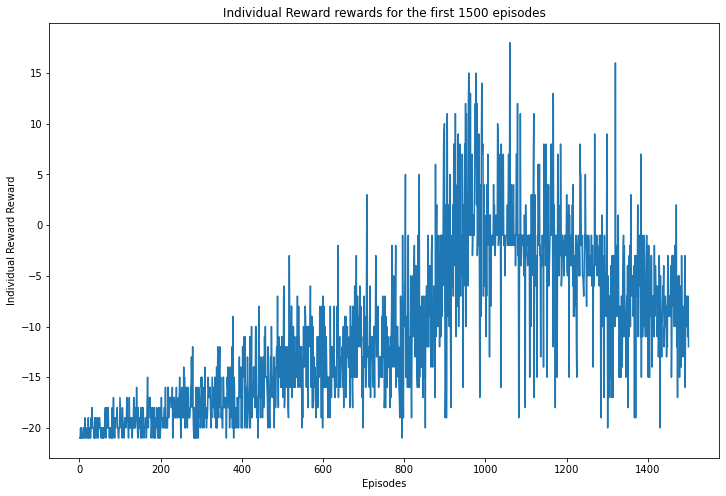

In [38]:
plot_rewards(re,1500,"Individual Reward",1)

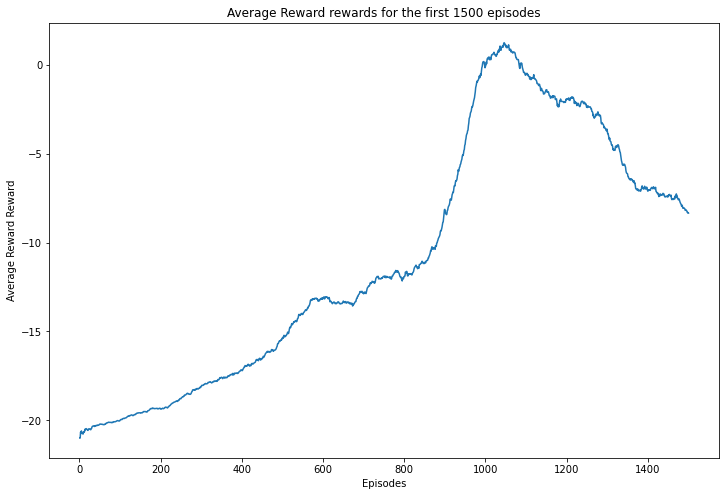

In [39]:
plot_rewards(ave_re,1500,"Average Reward",1)